# How to count and select coins from a given image

Analyzing input image WhiteBackground/IMG_20170128_134036.jpg


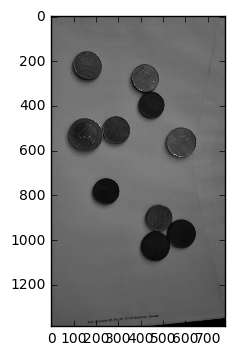

(1386, 778, 3)


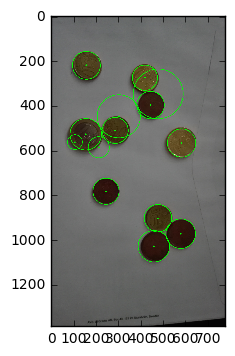

Trying para2... 51
Trying para2... 52
Trying para2... 52.5
Trying para2... 53.0
Total number of circles 10
(1386, 778, 3)


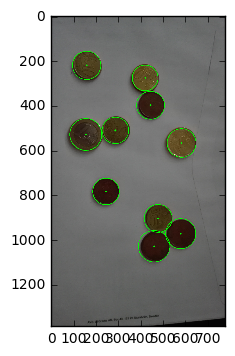

[154 532  71]
440 624 62 246


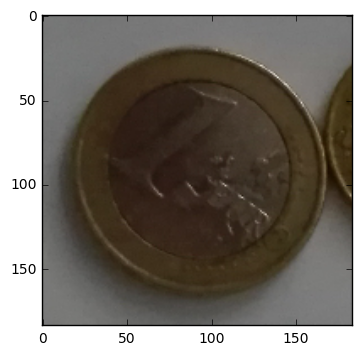

[418 280  57]
206 354 344 492


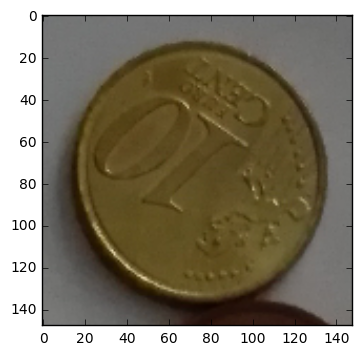

[158 224  63]
143 305 77 239


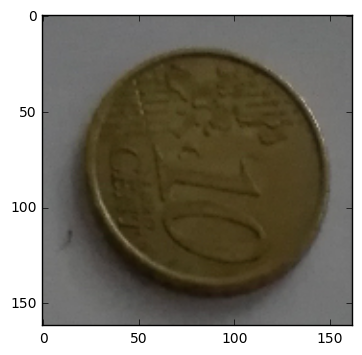

[580 570  64]
487 653 497 663


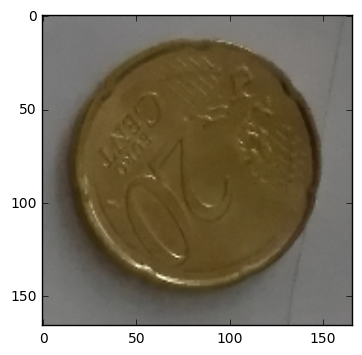

[244 786  59]
710 862 168 320


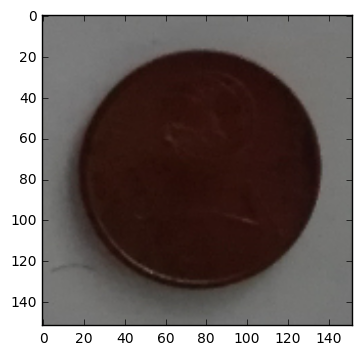

[286 514  59]
438 590 210 362


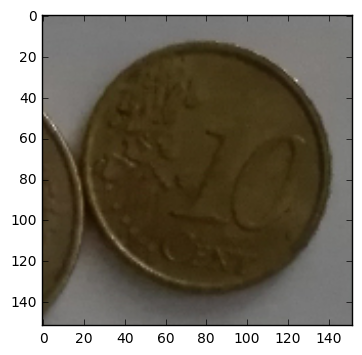

[442 402  62]
322 482 362 522


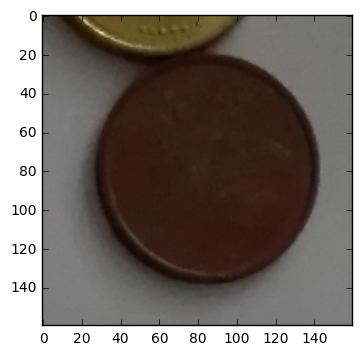

[476 906  62]
826 986 396 556


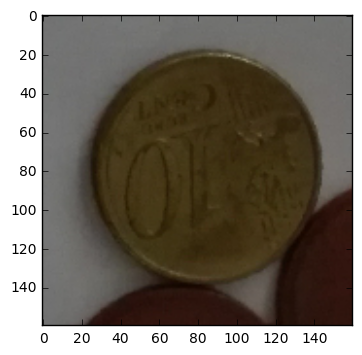

[576 974  67]
887 1061 489 663


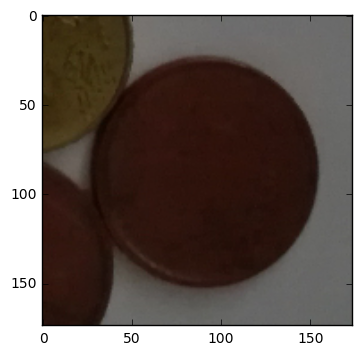

[ 458 1030   70]
939 1121 367 549


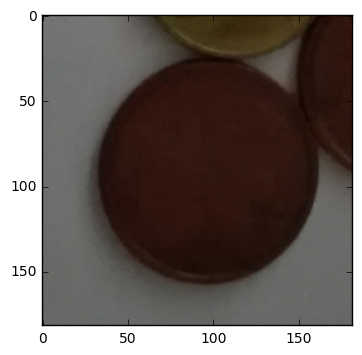

Saving Coins
ProcessedWhiteBackground/IMG_20170128_134036_Candidate_
WhiteBackground/IMG_20170128_134036.jpg
Saving Circles
Elapsed time: 4.036189 seconds.



In [25]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import copy
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

def showInformation(img):
    print(img.shape) #dimensions of input image
    plt.imshow(img)
    plt.show()

def applyFilters(channel):#Not used....

    channel = cv2.adaptiveThreshold(channel, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    #mop up the dirt
    channel = cv2.dilate(channel, None, 1)
    channel = cv2.erode(channel, None, 1) 

    return channel

def preProcessing(img):#Not used....
    # create tmp images
    processed = copy.deepcopy(img)
    b,g,r = cv2.split(img)

    #process each component
    b = applyFilters(b)
    g = applyFilters(g)
    r = applyFilters(r)

    processed = cv2.merge((b,g,r))

    return processed

def inter_centre_distance(x1,y1,x2,y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def colliding_circles(circles):
    if circles is not None:
        for i in circles[0,:]:
            for j in circles[0,:]:
                x1, y1, Radius1 = i
                x2, y2, Radius2 = j
                if i[0] == j[0] and i[1] == j[1]:
                    continue ## looking at the same circle
                
                #collision or containment:
                #print inter_centre_distance(x1,y1,x2,y2), Radius1, Radius2
                #if inter_centre_distance(x1,y1,x2,y2) < (Radius1 + Radius2)*0.95:
                if inter_centre_distance(x1,y1,x2,y2) < (Radius1 + Radius2)*0.85:
                    print("Warning: There are colliding circles "+str(len(circles[0,:])))
                    return True
    else:
        print("Warning: No circles found!")


def drawCircles(img,circles):
    cimg=copy.deepcopy(img)
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,255,0),3)
    return cimg
            
def findCircles(img, param1=50, param2=50):
    minDist = int(img.shape[1]/15) # To test
    minRadius = int(img.shape[1]/35) # To test
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.dilate(gray, None, 1)
    gray = cv2.erode(gray, None, 1) 
    
    plt.imshow(gray, cmap='gray')
    plt.show()

    try:
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,minDist, param1=param1, param2=param2, minRadius=minRadius)
        showInformation(drawCircles(img, circles))
    except:
        param2=int(param2/2) # largely reduce par2 to ensure convervence
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,minDist, param1=param1, param2=param2, minRadius=minRadius)    
        
    #Suspect that I miss circles
    while len(circles[0,:]) in range(0,11) and param2>=70: 
        param2 = param2 -5
        #twice the separation to reduce fakes
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,minDist, param1=param1, param2=param2, minRadius=minRadius)
        
    #Suspect that I have too many circles
    while colliding_circles(circles) == True:
        step = 0.5
        if len(circles[0,:]) > 12:
            step = 1
        if len(circles[0,:]) > 15:
            step = 2.5
        if len(circles[0,:]) > 20:
            step = 5
        param2 = param2 +step
        print("Trying para2... "+str(param2))
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,minDist, param1=param1, param2=param2, minRadius=minRadius)

    ncircles = len(circles[0,:])
    #Decrease the criteria to built a circle (at the risk of getting fakes) when low number of circles found.

    circles = np.uint16(np.around(circles))
    print("Total number of circles "+str(len(circles[0,:])))
    return circles

def showCandidates(img,circles):
    candidates = []
    for i in circles[0,:]:
        print(i) 
        xcenter = i[1]
        ycenter = i[0]
        radius = i[2] 
        radius_ext = int(radius*1.30) # extend the radius by 15% to get border of coin
        xmin = max(0, xcenter-radius_ext)
        xmax = min(img.shape[0], xcenter+radius_ext)
        ymin = max(0, ycenter-radius_ext)
        ymax = min(img.shape[1], ycenter+radius_ext)
        print(xmin, xmax, ymin, ymax)
        plt.imshow(img[xmin:xmax, ymin:ymax])
        plt.show()
        candidates.append(img[xmin:xmax, ymin:ymax])
    return candidates

def saveCandidates(outputfolder, source, candidates):
    print("Saving Coins")
    sourceSplit = source.split("/")
    if sourceSplit == source:
        sourceSplit = source.split("\\")
    output_filename = outputfolder+sourceSplit[-1].split(".")[0]+"_Candidate_"
    print(output_filename)
    print(source)
    for index, i in enumerate(candidates):
        #print index, i.shape
        img = Image.fromarray(i, 'RGB')
        img.save(output_filename+str(index+1)+".jpg")
    return 0

def saveCircles(outputfolder, source, cimg):
    print("Saving Circles")
    sourceSplit = source.split("/")
    if sourceSplit == source:
        sourceSplit = source.split("\\")
    output_filename = outputfolder+sourceSplit[-1].split(".")[0]+"_Circles"
    plt.imshow(cimg)
    img = Image.fromarray(cimg, 'RGB')
    img.save(output_filename+".jpg")
    return 0

#input information to explores
InputFolder = "WhiteBackground/" # Here I store the input images
CoinsOutputFolder = "ProcessedWhiteBackground/" # Here I store the pictures of individual coins
CirclesOutputFolder = "CirclesWhiteBackground/" # Here I store the pictures of individual coins


import glob
#input_file = glob.glob(InputFolder+"*.jpg") #Try new Samples

input_file = [InputFolder+"IMG_20170128_134036.jpg"]  #For debugging
#input_file = ["P70127-164848.jpg"]  #For debugging

for kfile in input_file:
    tic()
    print("Analyzing input image "+str(kfile))
    im = Image.open(kfile)                                                                              
    imarray = np.array(im)
    imgResized = cv2.resize(imarray, (int(imarray.shape[1]/3),int(imarray.shape[0]/3)), interpolation=cv2.INTER_CUBIC)
    #imgResized = cv2.resize(imarray, (int(imarray.shape[1]/2),int(imarray.shape[0]/2)), interpolation=cv2.INTER_CUBIC)
#    imarray = cv2.resize(imarray, (int(imarray.shape[1]/10),int(imarray.shape[0]/10)), interpolation=cv2.INTER_CUBIC)
    #showInformation(imarray)
    #imarray_processed = preProcessing(imarray)
    #showInformation(imarray_processed)
    circles = findCircles(imgResized)
    showInformation(drawCircles(imgResized, circles))
    candidates = showCandidates(imgResized, circles)
    #Saving output
    saveCandidates(CoinsOutputFolder, kfile, candidates)
    saveCircles(CirclesOutputFolder, kfile, drawCircles(imgResized, circles))
    toc()

# Create agumented (artificial data)

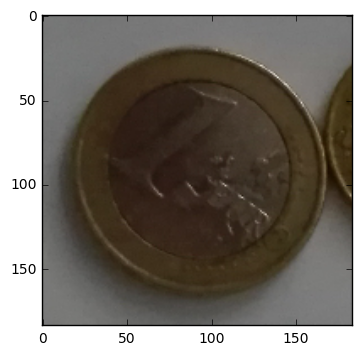

(184, 184, 3)


In [26]:
#Given one coing image, the goal is to create replicas of the same image under different transformations.
test_img= copy.deepcopy(candidates[0])
plt.imshow(test_img)
plt.show()
print(test_img.shape)

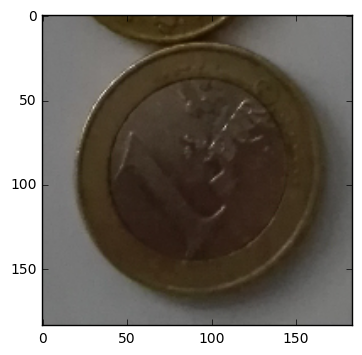

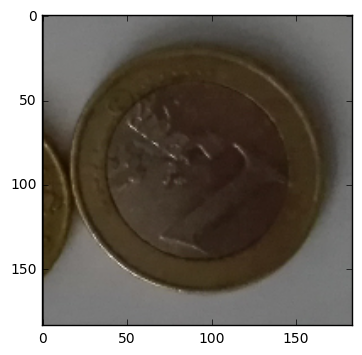

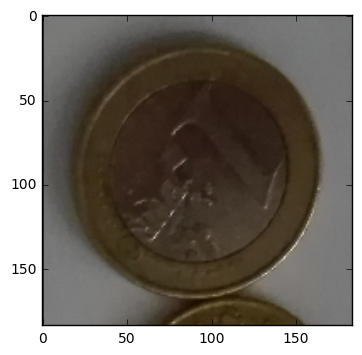

In [27]:
#Rotations
angles = [90,180,270]
for kAngle in angles:
    M = cv2.getRotationMatrix2D((test_img.shape[1]/2,test_img.shape[0]/2),kAngle,1)
    rotated_image = cv2.warpAffine(test_img,M,(test_img.shape[1],test_img.shape[0]))
    plt.imshow(rotated_image)
    plt.show()

# What should be the optimal resolution for training?

(184, 184, 3)


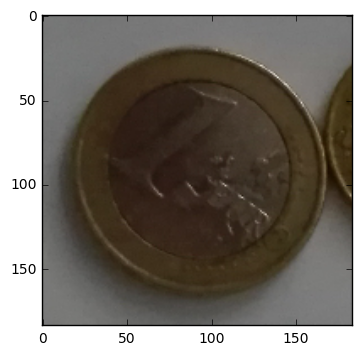

(92, 92, 3)


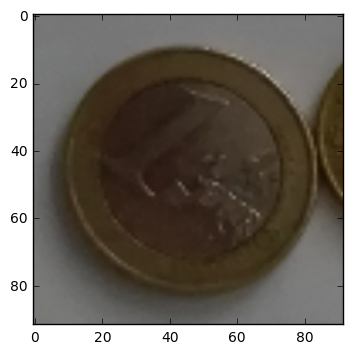

(61, 61, 3)


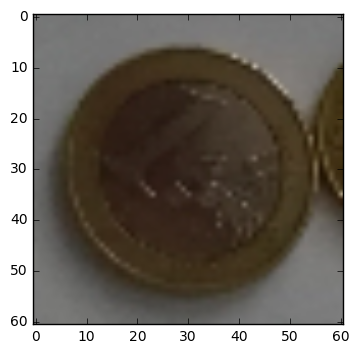

(46, 46, 3)


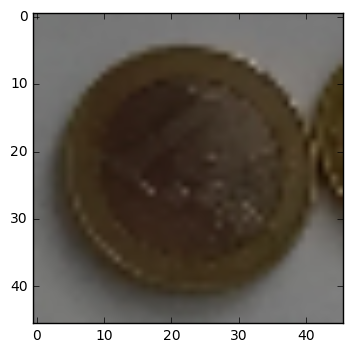

(36, 36, 3)


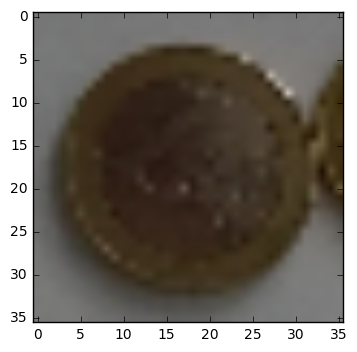

(30, 30, 3)


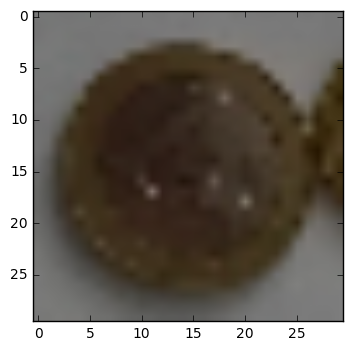

(26, 26, 3)


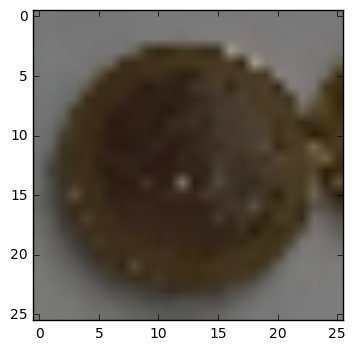

(23, 23, 3)


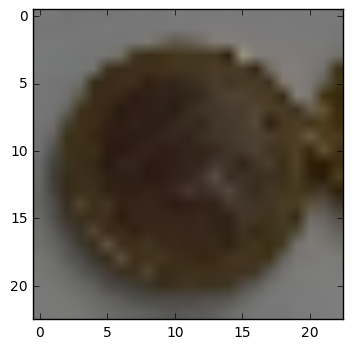

(20, 20, 3)


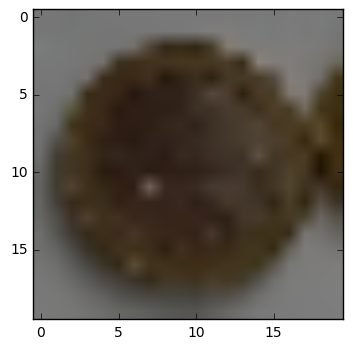

In [28]:
#playing with resolution
for i in range(1,10):
    showInformation(cv2.resize(test_img, (int(test_img.shape[1]/i),int(test_img.shape[0]/i)), interpolation=cv2.INTER_CUBIC))